# Waste Classification

## Introduction

*(...) "The world generates **2.01 billion tonnes of municipal solid waste annually**, with at least 33 percent of that-extremely conservatively-**not managed in an environmentally safe manner**. (...)"       - The World Bank Group, "Trends in Solid Waste Management" (2018)*
<br><br>

* 주제선정 배경
    *   생활수준 향상 등으로 전세계 쓰레기 배출 증가
    *   매립, 소각 -> 환경오염, 기상이변/발암물질 발생원인
    *   산업 발전에 따라 늘어나는 종류별 쓰레기 배출량 감당하기 어려워지고 있음
    *   자동화된 배출 쓰레기 분류 시스템을 통한 효율적/정확/안전한 분류. 관리 가능


## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os

from glob import glob
from tqdm import tqdm
import cv2

from sklearn.metrics import classification_report

import keras
from keras.layers import Dense, Dropout, Activation, Add, MaxPooling2D, MaxPool2D, Conv2D, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.models import Sequential
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, Model
from torchvision import models # datasets, transforms

# ResNet50 Transfer Learning #
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
##############################

import tensorflow_datasets as tfds
from IPython.display import clear_output
# from tensorflow_examples.models.pix2pix import pix2pix

import itertools

import warnings
warnings.filterwarnings('ignore')

## Google drive mount + unzip data file

In [2]:
import numpy as np
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/AIB14/Section4/섹션4프로젝트/data_s4_project.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: dataset/DATASET/TRAIN/R/R_5499.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_55.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_550.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5500.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5501.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5502.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5503.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5504.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5505.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5506.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5507.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5508.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5509.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_551.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5510.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5511.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5512.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5513.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5514.jpg  
  inflating: datas

## Look through data

In [5]:
train_path = "/content/DATASET/TRAIN/"
test_path = "/content/DATASET/TEST/"

In [7]:
x_data = [] 
y_data = [] 

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array) 
        y_data.append(category.split("/")[-1])
        
data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 12565/12565 [00:11<00:00, 1084.03it/s]


In [8]:
data.shape

(22564, 2)

In [9]:
from collections import Counter
Counter(y_data)

Counter({'R': 9999, 'O': 12565})



*   O -> Organic
*   R -> Recyclable



In [10]:
data.head()

,image,label
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",R
1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",R
2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",R
3,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",R
4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",R


In [11]:
def describeData(a, b):
  print('Total number of images: {}'.format(len(a)))
  print('Number of Organic Images: {}'.format(np.sum(b=='O')))
  print('Number of Recyclable Images: {}'.format(np.sum(b=='R')))

describeData(data['image'], data['label'])

# x = np.array(data['image']).astype('uint8')
# y = np.array(data['labels']).astype('uint8')

#     print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))

# describeData(x,y)

Total number of images: 22564
Number of Organic Images: 12565
Number of Recyclable Images: 9999


In [12]:
cla = ['O', 'R']
for cl in cla:
  print('{} {} images'.format(cla, len(os.listdir(os.path.join(train_path, cl)))))

['O', 'R'] 12565 images
['O', 'R'] 9999 images


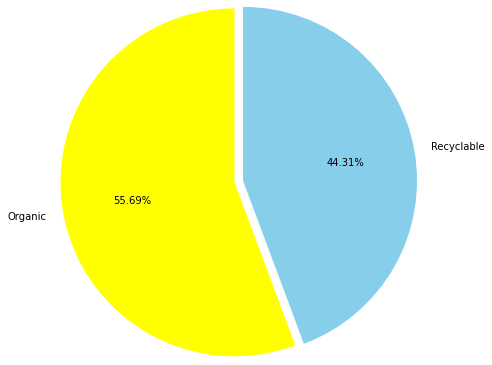

In [13]:
colors = ['yellow','skyblue']
plt.pie(data.label.value_counts()
        , startangle=90
        , explode=[0.05,0.05]
        , autopct='%0.2f%%'
        , labels=['Organic', 'Recyclable']
        , colors= colors
        , radius=2)
plt.show()

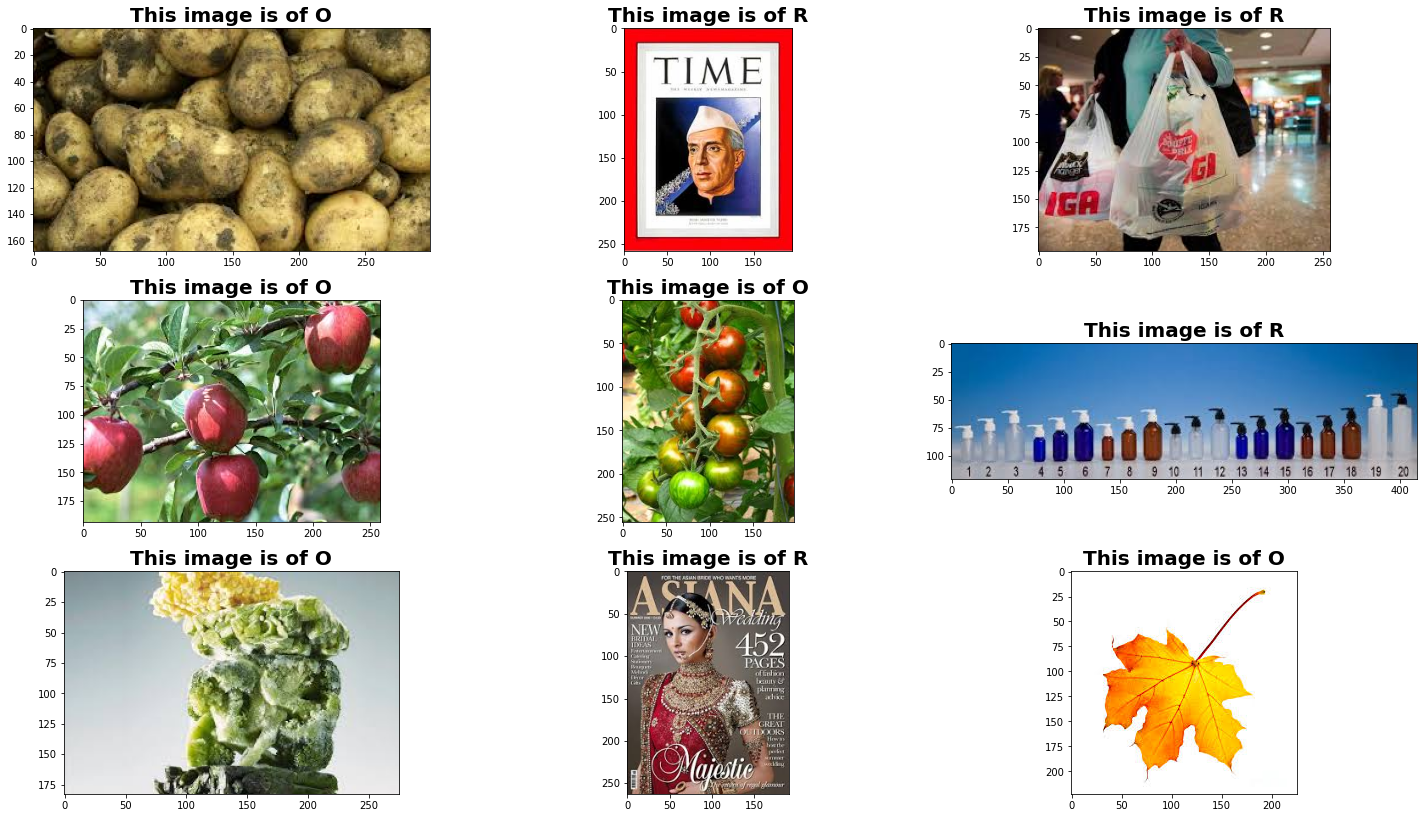

In [14]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(20000)
    plt.title('This image is of {0}'.format(data.label[index]),fontdict={'size':20,'weight':'bold'})
    plt.imshow(data.image[index])
    plt.tight_layout()

In [15]:
className = glob(train_path + '/*' )
num_of_classes = len(className)
print("Number Of Class: ", num_of_classes)

Number Of Class:  2


## Import data - ImageDataGenerator

*   쉽게 데이터 전처리 가능
*   데이터 증가 data augmentation: 기존 데이터에서 새로 생성된 합성 데이터를 추가 -> 정규화 역할, 기계학습 모델을 학습할 때 과적합을 줄이는 데 도움을 줌
<br>
*   **flow_from_directory**: 폴더 구조를 그대로 가져와 ImageDataGenerator에 실제 데이터를 채워줌 






In [16]:
train_datagen = ImageDataGenerator(rescale= 1./255, # rescale: 원본 영상은 0~255의 RGB 계수로 구성. 1./255로 스케일링하여 0~1 범위로 변환
                                   validation_split = 0.1)
                                    # rotation_range: 이미지 회전 범위 (0~10도 사이)
                                    # width_shift_range, height_shift_range: 그림을 수평/수직으로 랜덤하게 평행 이동시키는 범위
                                    # shear_range: 원본 이미지를 임의로 변형(전단)시키는 범위(늘이기)
                                    # zoom_range: 임의 확대/축소 범위 

val_datagen = ImageDataGenerator(rescale= 1./255,
                                 validation_split = 0.1)

# 255로 나누는 이유: 픽셀값이 0~255 사이의 값을 가진다고 했을 때, 0은 검은색/255는 흰색/1~254는 회색을 나타냄(grayscale 케이스)
# 0~1 값을 가지는 이유: 머신러닝에서 scale이 큰 특성의 영향이 커지는 것을 방지 + 극 값local minima에 빠질 확률을 감소시켜 학습속도 향상 (https://markme-inur.tistory.com/34)
# 참고. 공식문서 https://keras.io/api/preprocessing/image/

In [17]:
train_generator = train_datagen.flow_from_directory(
        train_path, 
        target_size= (224,224), # 사이즈 조정
        batch_size = 32,
        color_mode= "rgb",
        class_mode= "categorical",
        subset = 'training')
        # 훈련 이미지 경로
        # target_size: 이미지 크기(모든 이미지에 적용)
        # color_mode: 'grayscale'(흑백), 'rgb'(컬러)
        # batch_size: 한 배치 당 generator에서 생성할 이미지 개수
        # seed: 이미지를 임의로 섞기 위핸 랜덤 숫자
        # shuffle: 이미지를 섞어서 사용할지의 여부 결정
        # class_mode: 예측 클래스가 두 개라면 'binary', 그렇지 않으면 'categorical' > 2개인 경우에도 categorical 선택하는 경우?

val_generator = val_datagen.flow_from_directory(
        train_path, 
        target_size= (224,224),
        batch_size = 32,
        color_mode= "rgb",
        class_mode= "categorical",
        subset = 'validation')

print(val_generator.class_indices)

Found 20309 images belonging to 2 classes.
Found 2255 images belonging to 2 classes.
{'O': 0, 'R': 1}


In [18]:
X_train, y_train = train_generator.next()
X_val, y_val = val_generator.next()

print(X_train[0][0][0:10])
print(y_train[0:10])

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [19]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((32, 224, 224, 3), (32, 2), (32, 224, 224, 3), (32, 2))

In [20]:
classes = ['Organic','Recycle']

## Transfer Learning - ResNet50

1.   선정 모델: ResNet-50
2.   모델 선정 이유<br>
    *   imageNet에 훈련된 모델(가중치)을 가져와서 활용<br>
    *   본 프로젝트의 쓰레기 분류 이미지 데이터셋 특성상 해당 모델을 선정하는 것이 성능, 효율 면에서 적합하다고 판단<br>
    * val_accuracy가 가장 높은 값을 w_model.h5로 저장하여 분석에 활용

3. ~~단점~~<br>
    * ~~입력 제약이 매우 큼~~<br>
    * ~~충분한 메모리(RAM)가 없으면 학습 속도가 느릴 수 있음~~



In [21]:
# 1. instantiate a base model with pre-trained weights (https://keras.io/guides/transfer_learning/)

# Check properties of the model that we are going to use for Transfer Learning

resnet_base = ResNet50(input_shape=(224, 224, 3), # 입력 이미지에 대한 텐서 크기
                       weights = 'imagenet', # imageNet에서 사전 훈련된 값 (혹은, None: 무작위 초기화)
                       include_top = False) # 사전 훈련된 모델pre-trained model 상단에 '완전연결층(최상층 분류기)을 포함할지' 여부 지정 (default: True) / False: 직접 지정
                        # input_tensor: 입력 데이터의 텐서(layers.input()의 출력) / 텐서 = 데이터의 배열
                        # pooling: 풀링(sub-sampling, 특징 추출)에서 사용할 수 있는 값의 종류. (1) None: 모델의 출력이 마지막 합성곱층 (2) avg: 마지막 합성곱층에 글로벌 '평균' 풀링이 추가됨 (나누는 과정x, 각 feature map에 대해 모든 값을 더하는 단순 합으로 대체) (3) max: 마지막 합성곱층에 글로벌 '최대' 풀링이 적용됨
                        # classes: 이미지를 분류할 클래스의 선택적 수 (weights 로 'imagenet' 사용하려면 1000이어야 함, 다른 값을 사용하고 싶다면 None으로 지정)

# resnet_base.summary() 로 기존 모델 구조 확인

94781440/94765736 [==============================] - 1s 0us/step


In [22]:
# 2. freeze the base model
for layer in resnet_base.layers:
    layer.trainable = False # 훈련 가능/불가능(동결) 지정 (기존 가중치에 손상x)

In [23]:
# 3. create a new model on top - 이미 학습되어있는 ResNet50 모델을 내가 원하는 모델로 개조

x = resnet_base.output
x = GlobalAveragePooling2D()(x) # 1차원 벡터로 데이터 펴주기

predictions = Dense(2, activation='softmax')(x) # 출력층을 설계 - 소프트맥스가 포함된 밀집층 추가
model = Model(inputs = resnet_base.input, outputs = predictions)

# 4. train the model on new data
model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics= ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [24]:
#######참고#######
# https://www.kaggle.com/code/viratkothari/image-classification-transfer-learning-resnet50
# Modelling WITH Transfer Learning

## Fit Model

In [25]:
# 5. unfreeze the base model
resnet_base.trainable = True

In [26]:
# 6. re-compile model after making changes

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes are taken into account
# model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
#               loss=keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=[keras.metrics.BinaryAccuracy()])

model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [27]:
# checkpoint: 결과가 제일 높은 것만 w_model.h5 로 저장

# .h5 확장자: 학습시킨 model 을 파일로 저장
# HDF5 포맷으로 데이터를 저장한다는 의미
# 모델 및 가중치(weight)를 모두 가지고 있습니다.
# 참고. https://wooono.tistory.com/333

filepath = '/content/w_model.h5'
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_accuracy', 
                             verbose=1, # 0: 출력x 1: 훈련 진행도 표시 위한 진행 막대 표시 2: 미니 배치마다 훈련 정보 출력
                             save_best_only=True, 
                             mode='max')
# earlystopping
earlystop =  tf.keras.callbacks.EarlyStopping(monitor = "val_loss"
                                              , patience = 3
                                              , mode = "auto")

In [28]:
# 7. train end-to-end. (Be careful to stop before you overfit)
hist = model.fit_generator(
        generator = train_generator,
        epochs=20,
        validation_data = val_generator,
        callbacks = [checkpoint, earlystop])

Epoch 1/20
635/635 [==============================] - ETA: 0s - loss: 0.3977 - accuracy: 0.8516
Epoch 1: val_accuracy improved from -inf to 0.44302, saving model to /content/w_model.h5
635/635 [==============================] - 141s 194ms/step - loss: 0.3977 - accuracy: 0.8516 - val_loss: 2.1192 - val_accuracy: 0.4430
Epoch 2/20
635/635 [==============================] - ETA: 0s - loss: 0.3064 - accuracy: 0.8795
Epoch 2: val_accuracy improved from 0.44302 to 0.75211, saving model to /content/w_model.h5
635/635 [==============================] - 122s 192ms/step - loss: 0.3064 - accuracy: 0.8795 - val_loss: 0.5322 - val_accuracy: 0.7521
Epoch 3/20
635/635 [==============================] - ETA: 0s - loss: 0.2605 - accuracy: 0.8980
Epoch 3: val_accuracy improved from 0.75211 to 0.84213, saving model to /content/w_model.h5
635/635 [==============================] - 122s 191ms/step - loss: 0.2605 - accuracy: 0.8980 - val_loss: 0.3522 - val_accuracy: 0.8421
Epoch 4/20
635/635 [==============

In [29]:
resn = load_model('/content/w_model.h5')

## Accuracy & Loss Visualization

Accuracy plot (Training vs. Validation)

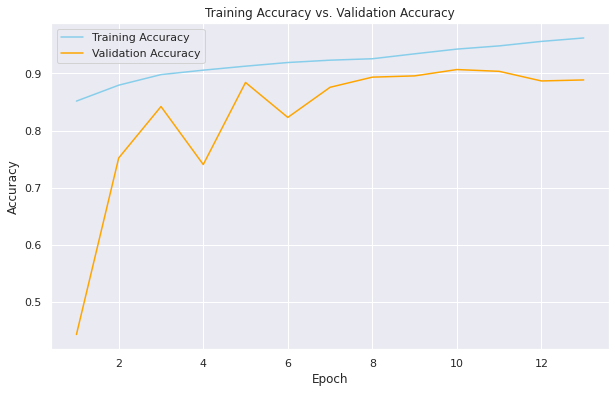

In [30]:
#plotting training values
sns.set()

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=[10,6])
plt.plot(epochs, acc, color='skyblue', label='Training Accuracy')
plt.plot(epochs, val_acc, color='orange', label='Validation Accuracy')
plt.title('Training Accuracy vs. Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Loss plot (Training vs. Validation)

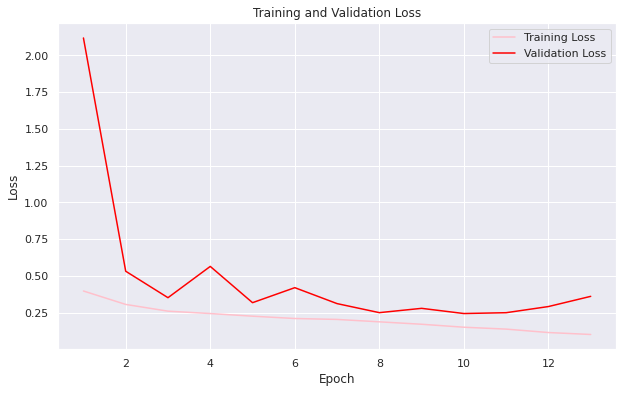

In [31]:
plt.figure(figsize = (10, 6))
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Loss plot2

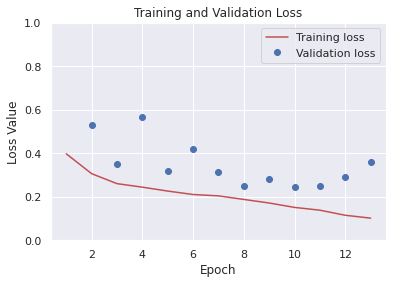

In [32]:
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## ETC

### Test Examples

example1.

[0]
Organic


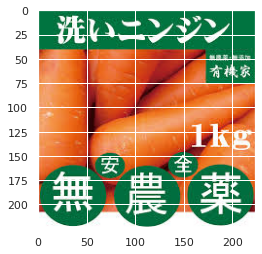

In [35]:
image_path = "/content/DATASET/TEST/O/O_12606.jpg"
new_img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)

pred = model.predict(img)
pred = np.argmax(pred, axis=1)

print(pred)
print(classes[pred[0]])
plt.imshow(new_img)

example2.

[0]
Organic


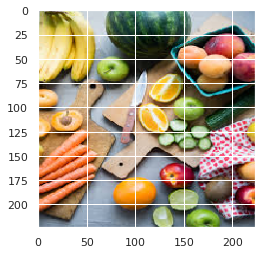

In [38]:
image_path = "/content/DATASET/TEST/O/O_13771.jpg"
new_img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)

pred = model.predict(img)
pred = np.argmax(pred, axis=1)

print(pred)
print(classes[pred[0]])
plt.imshow(new_img)

example3.

[0]
Organic


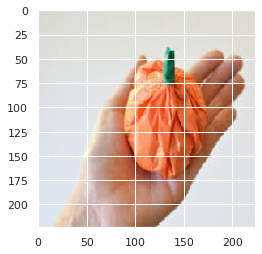

In [54]:
image_path = "/content/DATASET/TEST/R/R_10992.jpg"
new_img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)

pred = model.predict(img)
pred = np.argmax(pred, axis=1)

print(pred)
print(classes[pred[0]])
plt.imshow(new_img)

### Confusion Matrix

In [45]:
# make a prediction
predictions = model.predict_generator(val_generator, verbose=1) # len(df_val)

71/71 [==============================] - 6s 70ms/step


In [46]:
y_pred_val = np.argmax(predictions, axis=1) # Get the index of the class with the highest probability score
y_true_val = val_generator.classes # Get the labels of the test images.

In [47]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.figure(figsize=(100,100))
    plt.tight_layout()

In [48]:
# argmax returns the index of the max value in a row
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true_val, y_pred_val)

In [49]:
confusion_matrix(y_true_val, y_pred_val)

array([[767, 489],
       [581, 418]])

Confusion matrix, without normalization
[[767 489]
 [581 418]]


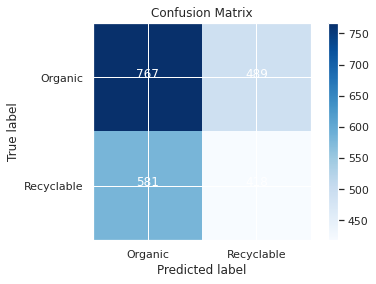

<Figure size 7200x7200 with 0 Axes>

In [50]:
# Key: Organic / Recyclable
# Define the labels of the class indices. These need to match the order shown above.

cm_plot_labels = ['Organic', 'Recyclable']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Classification Report

In [51]:
# Get the filenames, labels and associated predictions 
# outputs the sequence in which the generator processed the test images
val_filenames = val_generator.filenames

In [52]:
# Generate a classification report
names = ['Organic', 'Recyclable']
rep = classification_report(y_true_val, y_pred_val, target_names=names)

print(rep)

              precision    recall  f1-score   support

     Organic       0.57      0.61      0.59      1256
  Recyclable       0.46      0.42      0.44       999

    accuracy                           0.53      2255
   macro avg       0.51      0.51      0.51      2255
weighted avg       0.52      0.53      0.52      2255



**Recall** = Given a class, will the classifier be able to detect it? <br>
**Precision** = Given a class prediction from a classifier, how likely is it to be correct?<br>
**F1 Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.

The accuracy is above 90%. The F1 score is also above 90%. This tells us that our model is really good at detecting all classes, even the 'missing queen' class where only a 29 images are available.
<br><br>
As a side note - I'm wondering if the model is performing so well because it's looking at the bees or if it is actually looking at the background colour of the images. Maybe a more experienced data scientist can answer this question.